[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/okada-tak/deep-learning-from-scratch-2/blob/master/notebooks/ch01.ipynb)

# 1章 ニューラルネットワークの復習 のまとめ
- ニューラルネットワークは、入力層、隠れ層、出力層を持つ
- 全結合層によって線形な変換が行われ、活性化関数によって非線形な変換が行われる
- 全結合層やミニバッチ処理は、行列としてまとめて計算することができる
- 誤差逆伝播法を使って、効率的にニューラルネットワークの損失に関する勾配を求めることができる
- ニューラルネットワークで行う処理は、計算グラフによって可視化することができ、順伝播や逆伝播の理解に役立つ
- ニューラルネットワークの実装では、構成要素を「レイヤ」としてモジュール化することで、組み立てが容易になる
- ニューラルネットワークの高速化において、データのビット精度とGPUによる並列計算が重要である

## 1.1 数学とPythonの復習
### 1.1.1 ベクトルと行列

In [2]:
import numpy as np

x = np.array([1,2,3])
x.__class__

numpy.ndarray

In [3]:
x.shape

(3,)

In [4]:
x.ndim

1

In [5]:
W = np.array([[1,2,3], [4,5,6]])
W.shape

(2, 3)

In [6]:
W.ndim

2

### 1.1.2 行列の要素ごとの演算

In [7]:
W = np.array([[1,2,3], [4,5,6]])
X = np.array([[0,1,2], [3,4,5]])
W + X

array([[ 1,  3,  5],
       [ 7,  9, 11]])

In [8]:
W * X

array([[ 0,  2,  6],
       [12, 20, 30]])

### 1.1.3 ブロードキャスト

In [9]:
A = np.array([[1,2], [3,4]])
A * 10

array([[10, 20],
       [30, 40]])

In [10]:
A = np.array([[1,2], [3,4]])
b = np.array([10,20])
A * b

array([[10, 40],
       [30, 80]])

### 1.1.4 ベクトルの内積と行列の積
$x \cdot y = x_1y_1 +x_2y_2 + \cdots + x_ny_n$

In [11]:
# ベクトルの内積
a = np.array([1,2,3])
b = np.array([4,5,6])
np.dot(a,b)

32

In [12]:
# 行列の積
A = np.array([[1,2], [3,4]])
B = np.array([[5,6], [7,8]])
np.dot(A,B)

array([[19, 22],
       [43, 50]])

### 1.1.5 行列の形状チェック

## 1.2 ニューラルネットワークの推論
### 1.2.1 ニューラルネットワークの推論の全体図
$\mathbf{h = xW + b}$

In [14]:
import numpy as np
W1 = np.random.randn(2,4) # 重み
b1 = np.random.randn(4) # バイアス
x = np.random.randn(10,2) # 入力
h = np.dot(x, W1) + b1
h

array([[-0.6659767 ,  1.05461573, -1.49571023,  1.16642953],
       [-1.12109206, -0.0583981 , -0.4088617 ,  0.02210002],
       [-1.8169358 , -0.91570609, -3.48733254,  0.74850779],
       [-0.44770825,  0.8635589 ,  2.05199988, -0.41015876],
       [-0.81288749,  0.01564567,  2.67058935, -1.1959487 ],
       [-0.5795265 ,  1.38912004, -2.39310043,  1.74470708],
       [-1.76364078, -1.22272255, -1.15950902, -0.3998959 ],
       [ 0.10729616,  2.18901151,  0.90537943,  0.8919492 ],
       [-0.18641624,  1.20482169,  3.09940992, -0.62621791],
       [-2.08654203, -1.53527989, -3.06671867,  0.18721799]])

シグモイド関数  
$\sigma(x)=\frac{1}{1+\exp(-x)}$

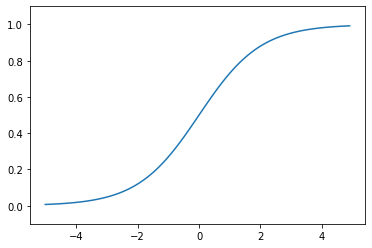

In [15]:
import numpy as np
import matplotlib.pylab as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

X = np.arange(-5.0, 5.0, 0.1)
Y = sigmoid(X)
plt.plot(X, Y)
plt.ylim(-0.1, 1.1)
plt.show()


In [16]:
# p.13
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(10,2)
W1 = np.random.randn(2,4)
b1 = np.random.randn(4)
W2 = np.random.randn(4,3)
b2 = np.random.randn(3)

h = np.dot(x, W1) + b1
a = sigmoid(h)
s = np.dot(a, W2) + b2
s

array([[ 0.51442667, -2.58486124,  1.33416118],
       [ 0.22234822, -0.63215792,  1.93209815],
       [ 0.24890326, -1.62312657,  2.08319597],
       [ 0.34067226, -1.40646221,  1.77498557],
       [ 0.15956215,  0.03677606,  1.97390948],
       [ 0.43419152, -1.94493797,  1.54854651],
       [ 0.24120465, -1.28225044,  2.0210727 ],
       [ 0.44188386, -1.78976274,  1.46985799],
       [ 0.46422495, -2.20831636,  1.47629334],
       [ 0.41498082, -1.50048229,  1.51950344]])

### 1.2.2 レイヤとしてのクラス化と順伝播の実装

ch01/forward_net.py

In [17]:
# coding: utf-8
import numpy as np


class Sigmoid:
    def __init__(self):
        self.params = []

    def forward(self, x):
        return 1 / (1 + np.exp(-x))


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        return out


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 重みとバイアスの初期化
        W1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = np.random.randn(H, O)
        b2 = np.random.randn(O)

        # レイヤの生成
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]

        # すべての重みをリストにまとめる
        self.params = []
        for layer in self.layers:
            self.params += layer.params

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x


x = np.random.randn(10, 2)
model = TwoLayerNet(2, 4, 3)
s = model.predict(x)
print(s)

[[-0.41320702 -0.24111715  1.16219164]
 [-1.24332172 -0.42208963 -0.3481583 ]
 [-0.69039598 -0.92300762  0.10894589]
 [-0.92934725  0.0416379   0.53238381]
 [-1.09827557  0.26831106  0.58186764]
 [-1.205731   -0.51024032 -0.34824769]
 [-0.40087989 -0.06745483  1.32370045]
 [-0.45601484 -0.59616875  0.82051116]
 [-0.73904394  0.07639788  0.920552  ]
 [-0.70183842  0.10936541  1.02914239]]


## 1.3 ニューラルネットワークの学習
### 1.3.1 損失関数
■Softmax関数  
$$
y_k = \frac{\exp(s_k)}{\displaystyle \sum_{i=1}^n \exp(s_i)}
$$
$y_k$ : $k$番目の出力  
$s_k$ : $k$番目のスコア   

■交差エントロピー誤差
$$
L=-\sum_k t_k \log{y_k}
$$
$\log$ : 底が$e$の自然対数（$\log_e$)  
$y_k$ : ニューラルネットワークの出力  
$t_k$ : 教師ラベル（正解ラベルとなるインデックスだけが1で、その他は0（one-hot表現））  
$k$ : データの次元数（ただし正解ラベル以外は0となるので正解ラベルのみ計算すればよい）  

■交差エントロピー誤差（ミニバッチ対応）  
$$
L=-\frac{1}{N}\sum_n \sum_k t_{nk} \log{y_{nk}}
$$
$N$：データの個数

### 1.3.2 微分と勾配
$L=f(\rm{x})$, $L$:スカラ, $\rm{x}$:ベクトル  
ベクトルの各要素に関する微分をまとめて**勾配** 

$$
\frac{\partial L}{\partial \rm{x}}=\left( \frac{\partial L}{\partial x_1}, \frac{\partial L}{\partial x_2}, \cdots, \frac{\partial L}{\partial x_n} \right)
$$

$\mathbf W$: $m \times n$の行列として$L=g(\mathbf W)$という関数の勾配は以下  


$$
\frac{\partial L}{\partial \mathbf W}=
\begin{pmatrix}
\frac{\partial L}{\partial W_{11}} & \cdots & \frac{\partial L}{\partial W_{1n}}\\
\vdots & \ddots &        &  \\
\frac{\partial L}{\partial W_{m1}} &  & \frac{\partial L}{\partial W_{mn}}
\end{pmatrix}
$$

### 1.3.3 チェインルール
$y=f(x), z=g(y)$  
$z=g(f(x))$  

合成関数の微分 - $x$に関する$z$の微分 - は以下  

$$
\frac{\partial z}{\partial x}=\frac{\partial z}{\partial y}\frac{\partial y}{\partial x}
$$

### 1.3.4 計算グラフ
#### 1.3.4.1 乗算ノード
#### 1.3.4.2 分岐ノード
#### 1.3.4.3 Repeatノード


In [21]:
import numpy as np
D, N = 8, 7
x = np.random.randn(1, D) # 入力
y = np.repeat(x, N, axis=0) # forward
dy = np.random.randn(N, D) # 仮の勾配
dx = np.sum(dy, axis=0, keepdims=True) # backward
dx

array([[ 1.95647112,  1.03571187,  3.22773239,  0.07572132, -3.25809953,
        -1.65043012, -3.71719272,  2.39647124]])

#### 1.3.4.4 Sumノード

In [22]:
import numpy as np
D, N = 8, 7
x = np.random.randn(1, D) # 入力
y = np.sum(x, axis=0, keepdims=True) # forward
dy = np.random.randn(1, D) # 仮の勾配
dx = np.repeat(dy, N, axis=0) # backward
dx

array([[-0.01129201,  0.28375146,  1.13895337,  1.41967447, -0.57879809,
         0.68506664,  0.95844008, -1.36485711],
       [-0.01129201,  0.28375146,  1.13895337,  1.41967447, -0.57879809,
         0.68506664,  0.95844008, -1.36485711],
       [-0.01129201,  0.28375146,  1.13895337,  1.41967447, -0.57879809,
         0.68506664,  0.95844008, -1.36485711],
       [-0.01129201,  0.28375146,  1.13895337,  1.41967447, -0.57879809,
         0.68506664,  0.95844008, -1.36485711],
       [-0.01129201,  0.28375146,  1.13895337,  1.41967447, -0.57879809,
         0.68506664,  0.95844008, -1.36485711],
       [-0.01129201,  0.28375146,  1.13895337,  1.41967447, -0.57879809,
         0.68506664,  0.95844008, -1.36485711],
       [-0.01129201,  0.28375146,  1.13895337,  1.41967447, -0.57879809,
         0.68506664,  0.95844008, -1.36485711]])

#### 1.3.4.5 MatMulノード

common/layers.py

In [24]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

### 1.3.5 勾配の導出と逆伝播の実装
#### 1.3.5.1 Sigmoidレイヤ
シグモイド関数  
$$\sigma(x)=\frac{1}{1+\exp(-x)}$$  

シグモイド関数の微分  
$$
\frac{\partial y}{\partial x}=y(1-y)
$$


common/layers.py

In [23]:
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

#### 1.3.5.2 Affineレイヤ
Affineレイヤの順伝播  
y = np.dot(x, W) + b

common/layers.py

In [25]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

#### 1.3.5.3 Softmax with Lossレイヤ

common/layers.py

In [26]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

# ■Colaboratory用
Google Colaboratoryの場合、Google Driveに  
dl-from-scratch-2/ch04  
というフォルダを用意し、そこにこのjupyter notebookを配置。  
(dl-from-scratchの部分は任意。)  
また、datasetフォルダとcommonフォルダを
dl-from-scratch/dataset  
dl-from-scratch/common
にコピーしておく。  

以下のセルでGoogle Driveをマウント。許可を求められるので許可する。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ■追記（岡田）Colaboratory用
chdirする。

In [1]:
import sys,os
os.chdir('/content/drive/My Drive/dl-from-scratch-2/')
os.getcwd()

FileNotFoundError: ignored